### Genetic Variant Classification:
   The Dataset being used was gathered by ClinVar, a public resource used to collect information about genetic variants. ClinVar classifies each of these variants into one of three categories:
   1. Likely Benign or Benign
   2. VUS
   3. Likely Pathogenic or Pathogenic
   
The variants were categorized via manual testing by multiple labs. Conflicting categorizations have been assigned to the CLASS column, a 1 represents a conflicting categorizations by different labs while a 0 represents a consistent categorization.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn as sk
import fractions
import re
import seaborn as sns

## EDA

In [2]:
dataframe = pd.read_csv("~/Desktop/clinvar_conflicting.csv", dtype={0: object, 38: str, 40: object})

In [3]:
print(dataframe.shape)
dataframe.head()

(65188, 46)


,CHROM,POS,REF,ALT,AF_ESP,AF_EXAC,AF_TGP,CLNDISDB,CLNDISDBINCL,CLNDN,...,SIFT,PolyPhen,MOTIF_NAME,MOTIF_POS,HIGH_INF_POS,MOTIF_SCORE_CHANGE,LoFtool,CADD_PHRED,CADD_RAW,BLOSUM62
0,1,955563,G,C,0.0000,0.00000,0.0000,"MedGen:C3808739,OMIM:615120|MedGen:CN169374",NaN,"Myasthenic_syndrome,_congenital,_8|not_specified",...,NaN,NaN,NaN,NaN,NaN,NaN,0.421,11.390,1.133255,-2.0
1,1,955597,G,T,0.0000,0.42418,0.2826,MedGen:CN169374,NaN,not_specified,...,NaN,NaN,NaN,NaN,NaN,NaN,0.421,8.150,0.599088,NaN
2,1,955619,G,C,0.0000,0.03475,0.0088,"MedGen:C3808739,OMIM:615120|MedGen:CN169374",NaN,"Myasthenic_syndrome,_congenital,_8|not_specified",...,NaN,NaN,NaN,NaN,NaN,NaN,0.421,3.288,0.069819,1.0
3,1,957640,C,T,0.0318,0.02016,0.0328,"MedGen:C3808739,OMIM:615120|MedGen:CN169374",NaN,"Myasthenic_syndrome,_congenital,_8|not_specified",...,NaN,NaN,NaN,NaN,NaN,NaN,0.421,12.560,1.356499,NaN
4,1,976059,C,T,0.0000,0.00022,0.0010,MedGen:CN169374,NaN,not_specified,...,NaN,NaN,NaN,NaN,NaN,NaN,0.421,17.740,2.234711,NaN


In observing the CLASS variable we can see that it is heavily skewed towards consistent categorizations (CLASS = 0). This gives us context for observing the ratio of conflicting classifications as grouped by each variable.

CLASS
0    48754
1    16434
dtype: int64
The fraction of classifications that are conflicting is 0.2521016137939498


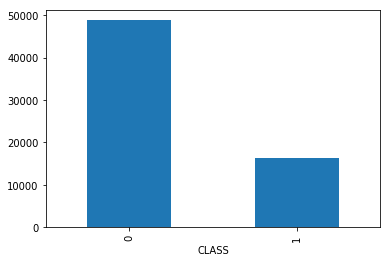

In [4]:
#plotting a histogram of the different values of class to see if it's skewed
g = dataframe.groupby('CLASS').size()
g.plot(kind = 'bar')
proportion_conflicting = g[1]/g.sum()
print(g)

print("The fraction of classifications that are conflicting is {}".format(proportion_conflicting))

In order to accurately compare the proportions of the rate of conflicting classifications I've organized the proportion of conflicting classifications by mutation. What is interesting about these classifications is that the misclassification rate for single_nucleotide_variant (often abreviated SNP) is higher than that of the other mutations. SNP's are mutations in which only a single nucleotide is changed as opposed to deletions or insertions in which multiple alleles are affected. We can also see that Microsatellite variations have significantly different values than the others however due to the small sample size we cannot draw any firm conclusions from this.

Proportion of conflicting classifications by mutation CLNVC
Deletion                     0.180151
Duplication                  0.210832
Indel                        0.161943
Insertion                    0.147368
Inversion                    0.235294
Microsatellite               0.600000
single_nucleotide_variant    0.256246
Name: CLASS, dtype: float64 

Proportion of conflicting classifications by mutation compared to average for data set CLNVC
Deletion                    -0.071950
Duplication                 -0.041270
Indel                       -0.090158
Insertion                   -0.104733
Inversion                   -0.016807
Microsatellite               0.347898
single_nucleotide_variant    0.004144
Name: CLASS, dtype: float64



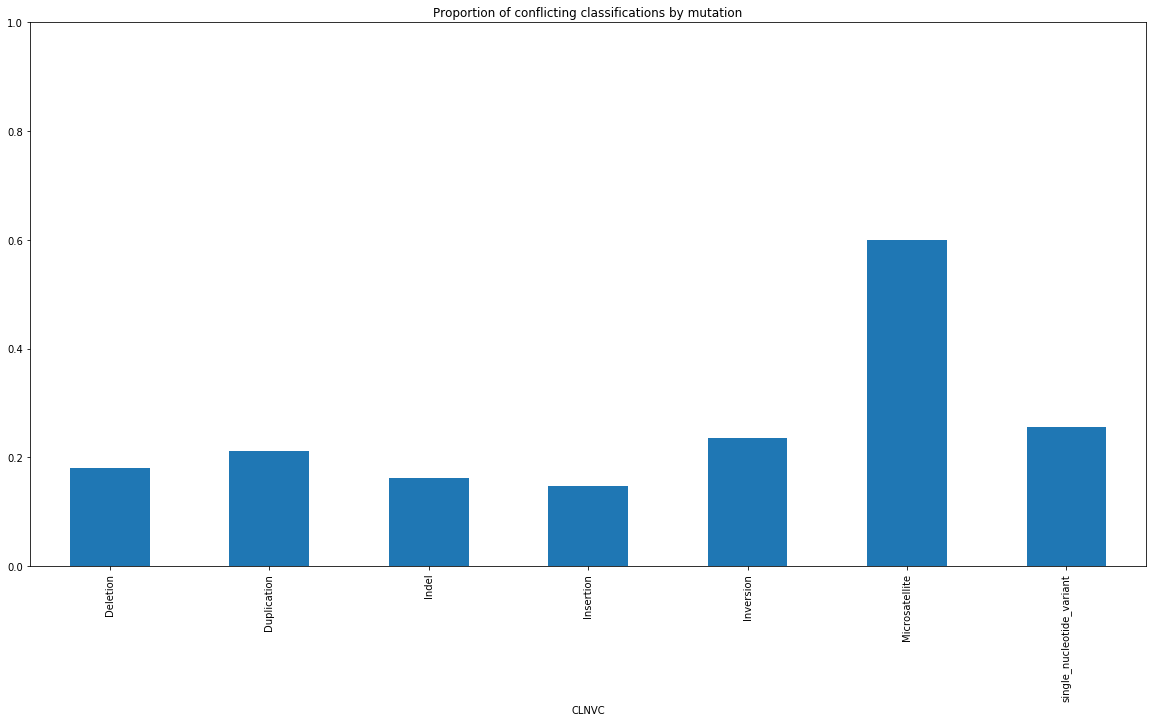

In [5]:
#Testing Categorical Variables

grouped = dataframe.groupby('CLNVC')
grouped_class = grouped['CLASS'].agg(np.mean)

print("Proportion of conflicting classifications by mutation {} \n".format(
    grouped_class))

#comparing proportion of each mutation conflicting to average
print("Proportion of conflicting classifications by mutation compared to average for data set {}\n".format(
    grouped_class.apply(lambda grouped_class: grouped_class - proportion_conflicting)))
grouped.size()

grouped_class.plot(kind = "bar", ylim = [0,1], title = 'Proportion of conflicting classifications by mutation', figsize = (20,10))


I've performed a similar analysis to that done on the CLNVC variable on IMPACT. In comparing the proportion of conflicting classifications of each impact level we can clearly see that HIGH values have a lower conflicting classification rate than other values. (more information about the impact variable is explained at https://uswest.ensembl.org/info/genome/variation/prediction/predicted_data.html#consequences.) Essentially the IMPACT measures the predicted impact of the variant on phenotype. This analysis seems to indicate that variants that have a high impact on phenotype seems to lead to less conflicting results with regard to pathogeneity. This seems reasonable, however the results also indicate that there is essentially no difference between the misclassification of a LOW impact and MODERATE impact variation which would seem to deserve attention.

Proportion of conflicting classifications by impact level IMPACT
HIGH        0.071759
LOW         0.267905
MODERATE    0.265145
MODIFIER    0.266750
Name: CLASS, dtype: float64 
 

Proportion of conflicting classifications by impact level compared to average for data setIMPACT
HIGH       -0.180342
LOW         0.015803
MODERATE    0.013044
MODIFIER    0.014649
Name: CLASS, dtype: float64

IMPACT
HIGH         4752
LOW         21642
MODERATE    33212
MODIFIER     5582
dtype: int64


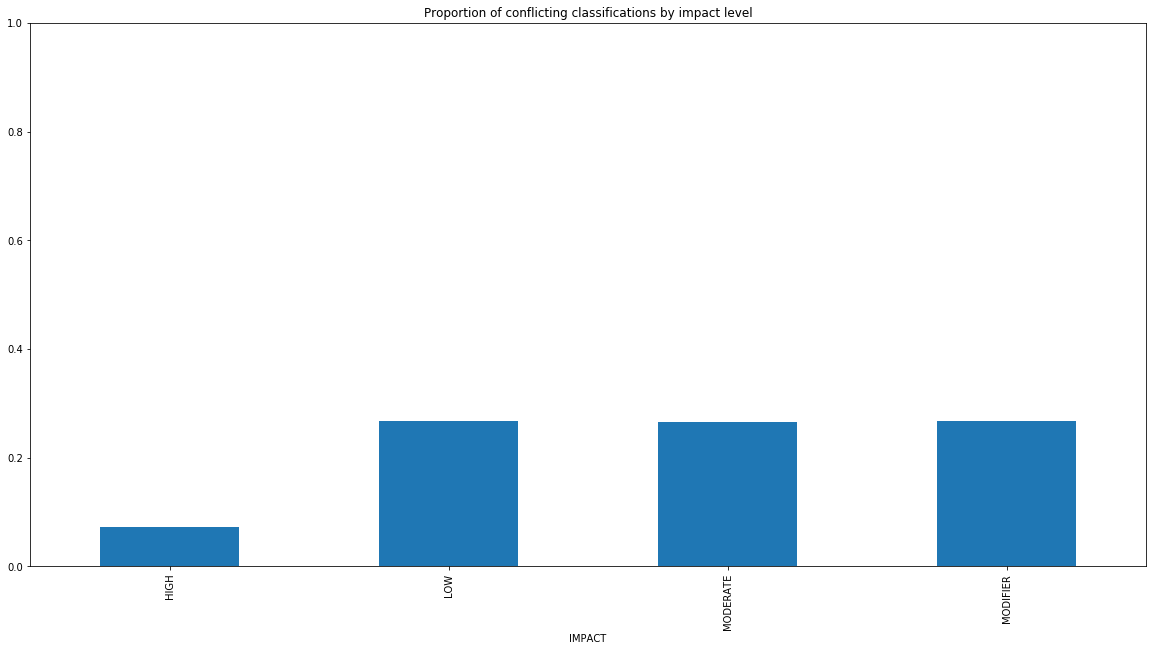

In [6]:
#IMPACT

grouped_impact = dataframe.groupby('IMPACT')
grouped_impact_class = grouped_impact['CLASS'].agg(np.mean)

print("Proportion of conflicting classifications by impact level {} \n \n".format(
    grouped_impact_class))

#comparing proportion of each IMPACT level conflicting to average
print("Proportion of conflicting classifications by impact level compared to average for data set{}\n".format(
    grouped_impact_class.apply(lambda grouped_impact_class: grouped_impact_class - proportion_conflicting)))

print(grouped_impact.size())

grouped_impact_class.plot(kind = "bar", ylim = [0,1], title = 'Proportion of conflicting classifications by impact level',
                          figsize = (20,10))

In [7]:
#creating function for correlation plot
def plot_corr(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''
    corr = df.corr()

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(20, 10))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, cmap=cmap, vmax= 1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
    


In the cell below I've created a purely numeric data frame that can be used for model creation, I've eliminated all non-numeric features, in addition to this I've removed the NA values from the data.

In [8]:
#dropping all columns with over 20% NA
df=dataframe.replace({'':np.nan})
df = df.dropna(thresh=0.8*len(df), axis=1)
df.columns
#dropping all columns that clearly don't play a role in outcome (ex: clinical name of diseases)
df = df.drop(["CLNDISDB", "CLNDN", "Feature", 'Consequence', 'BIOTYPE', 'SYMBOL', 'Feature_type', 'ORIGIN'], axis = 1)
#removing all non numerical values
df_numeric = df.drop(['Amino_acids', 'Codons', 'MC', "CLNHGVS", 'REF', 'ALT', 'CLNVC', 'Allele', 'IMPACT', 'CHROM'], axis = 1)

#converting variables with numeric values listed as strings to numeric
for i in ["Protein_position", "CDS_position", "cDNA_position"]:
    df_numeric[i] = pd.to_numeric(df_numeric[i], errors = 'coerce')
    

#converting EXON to numeric values
df_numeric.EXON.fillna('0', inplace=True)
df_numeric['variant_exon'] = df_numeric.EXON.apply(lambda x: [float(s) for s in re.findall(r'\b\d+\b', x)][0])
df_numeric = df_numeric.drop(["EXON"], axis = 1)

df_numeric.dropna(axis = 0, inplace = True)
df_numeric.head()

,POS,AF_ESP,AF_EXAC,AF_TGP,CLASS,cDNA_position,CDS_position,Protein_position,STRAND,LoFtool,CADD_PHRED,CADD_RAW,variant_exon
0,955563,0.0000,0.00000,0.0000,0,61.0,11.0,4.0,1.0,0.421,11.390,1.133255,1.0
1,955597,0.0000,0.42418,0.2826,0,95.0,45.0,15.0,1.0,0.421,8.150,0.599088,1.0
2,955619,0.0000,0.03475,0.0088,1,117.0,67.0,23.0,1.0,0.421,3.288,0.069819,1.0
3,957640,0.0318,0.02016,0.0328,0,311.0,261.0,87.0,1.0,0.421,12.560,1.356499,2.0
4,976059,0.0000,0.00022,0.0010,1,576.0,526.0,176.0,1.0,0.421,17.740,2.234711,4.0


The correlation plot indicates that none of the values are highly correlated with the CLASS variable, this indicates that a model with a low risk of overfitting can't be created by training on a select subset of features.

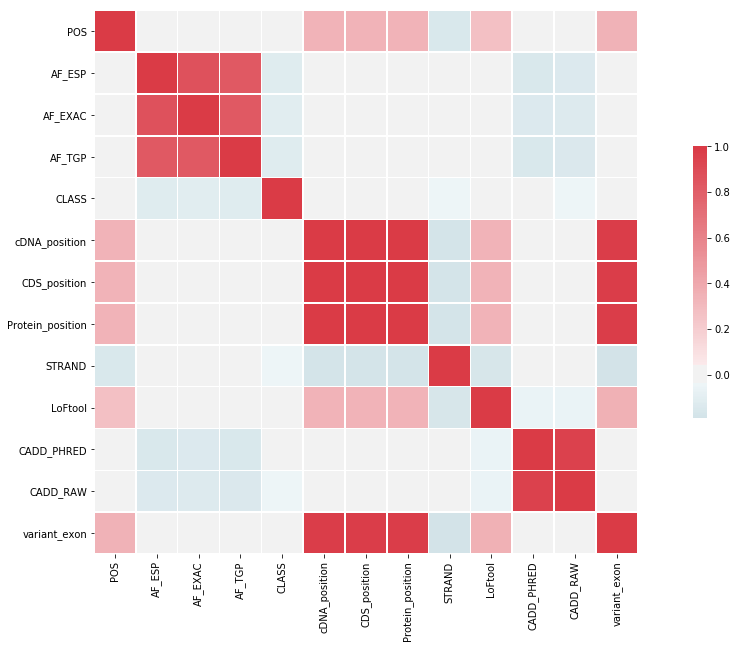

In [9]:
plot_corr(df_numeric, size = 20)

Both the logistic regression model and SVM create models with roughly 75% accuracy in their predictions. Although these results aren't extraordinary it also seems unlikely that further tuning will lead to a large increase in accuracy as none of the features are highly correled with CLASS.

In [10]:
#splitting data into training and test sets
from sklearn.model_selection import train_test_split
df_numeric_predictors = df_numeric.drop(["CLASS"], axis = 1)
df_numeric_outcome = df_numeric["CLASS"]
X_train, X_test, y_train, y_test = train_test_split(df_numeric_predictors, df_numeric_outcome, test_size=0.33, random_state=42)

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
#training the model using training sets
regr = LogisticRegression().fit(X_train, y_train)
#testing the model using testing sets
y_pred = regr.predict(X_test)

y_array = np.array(y_test)
print('Accuracy score: %.2f' % accuracy_score(y_array, y_pred))


Accuracy score: 0.75


In [12]:
from sklearn import svm
clf = svm.SVC(gamma = 0.001)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy score: %.2f' % accuracy_score(y_test, y_pred))

Accuracy score: 0.74


## Conclusions
    This data set showed some interesting results. Probably the most surprising was revealed during the EDA when we saw how strongly correlated SNP mutations were with misclassifications this can lead to interesting questions with regards to testing methods for SNP mutations and their consistency. A more accurate model could possibly have been created if the methods and features used were fine tuned but the central goal of this analysis was more along the lines of data exploration and noticing irregularities that could point towards further research.

In [ ]:
All of the data used can be accessed at 